##Домашнее задание № 3. Модели ARMA.

##Загрузим необходимые данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-23 17:17:42--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip’

1._Лекция_tsml.zip  100%[===================>] 751.03K   749KB/s    in 1.0s    

2025-02-23 17:17:45 (749 KB/s) - ‘1._Лекция_tsml.zip’ saved [769056/769056]



In [3]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [4]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [5]:
series = monthly_boston_armed_robberies_j['Count']

In [6]:
# вывод графика
def chart(series, title='Временной ряд'):
    plt.figure(figsize=(14, 7))
    plt.plot(series, label=title)
    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

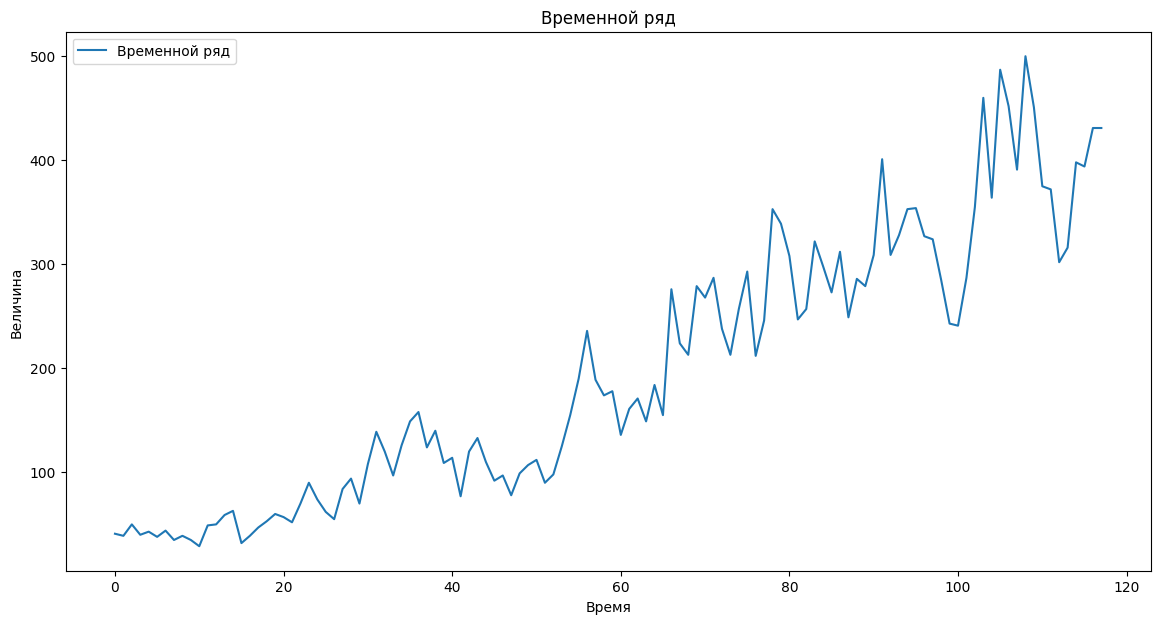

In [7]:
# еще раз на него посмотрим
chart(series)

Построим на его основе стационарный ряд

In [8]:
# зададим размер окна
window = 12

# вычислим скользящее среднее
rolling_mean = series.rolling(window=window).mean()

# детерминируем тренд
detrended = series - rolling_mean

# переиндексируем
stationary = detrended.dropna().diff().dropna().reset_index()['Count']
stationary[:3]

,Count
0,0.250000
1,7.333333
2,2.916667


In [9]:
# проверим на стационарность
from statsmodels.tsa.stattools import adfuller

res = adfuller(stationary.dropna())
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

Augmneted Dickey_fuller Statistic: -7.780023
p-value: 0.000000


In [10]:
# загрузим библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [12]:
# Fit the ARMA(1, 1) model
model = ARIMA(stationary, order=(1, 0, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  106
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -533.883
Date:                Sun, 23 Feb 2025   AIC                           1075.765
Time:                        17:19:22   BIC                           1086.419
Sample:                             0   HQIC                          1080.083
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0966      0.255      0.379      0.705      -0.403       0.596
ar.L1          0.5363      0.098      5.464      0.000       0.344       0.729
ma.L1         -0.9999      9.571     -0.104      0.9

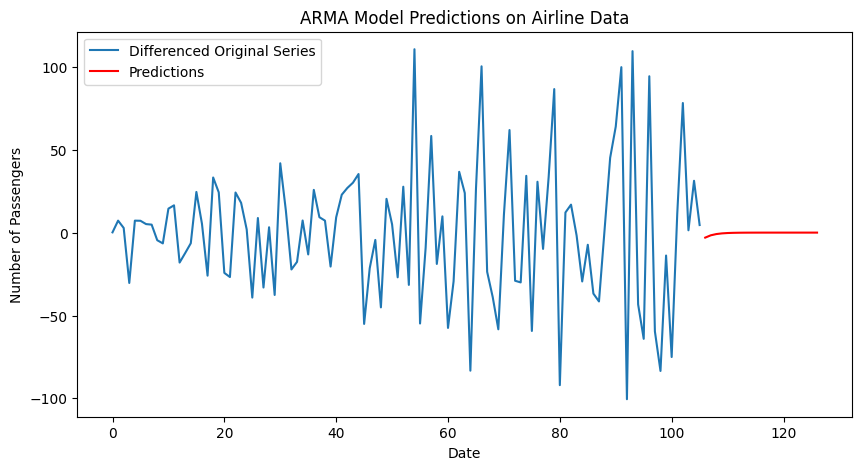

In [13]:
# Make predictions
start = len(stationary)
end = start + 20
predictions = model_fit.predict(start=start, end=end)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(stationary, label='Differenced Original Series')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('ARMA Model Predictions on Airline Data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

##1. Скользящее среднее (MA)

###1.1. Не стационарный ряд

Для сопоставимости результатов здесь и далее размер окна всегда будет 12

In [ ]:
# зададим размер окна
window = 12
# получим результат
ma = series.rolling(window).mean()

In [ ]:
# вывод графиков
def chart_2(series_1, series_2, title):
    plt.figure(figsize=(14, 7))
    plt.plot(series_1, label='Временной ряд')
    plt.plot(series_2, label=title)
    plt.title('Визуальное сравнение полученного временного ряда')
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

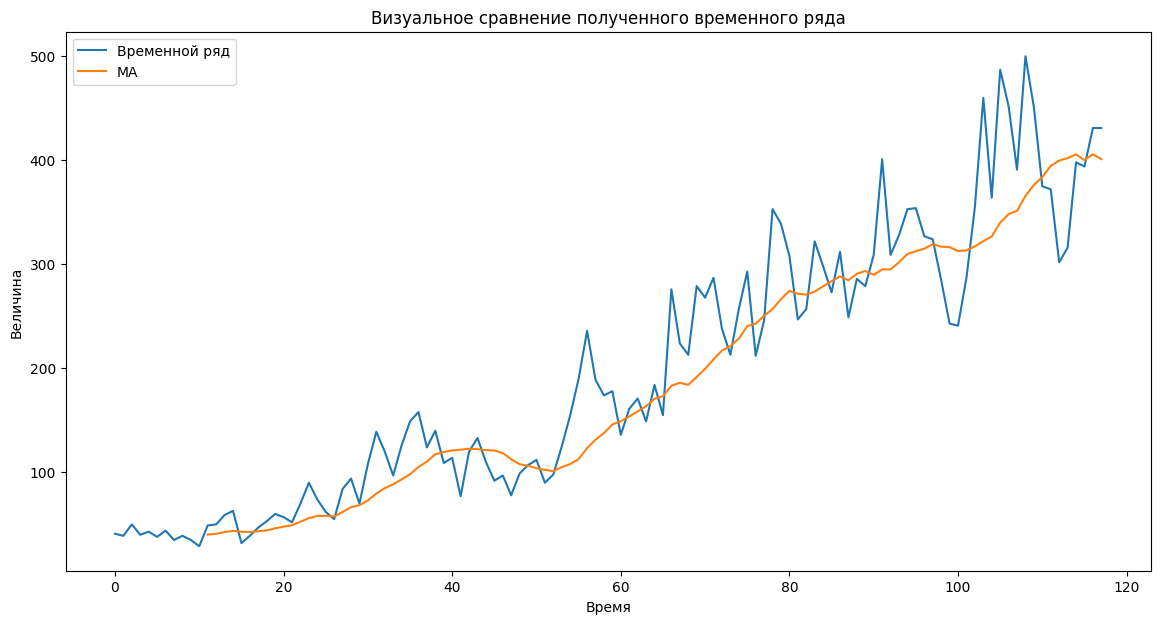

In [ ]:
chart_2(series, ma, "MA")

In [ ]:
# попрообую рассчитать RMSE
from sklearn.metrics import mean_squared_error
def rsme(series_t, series_p, window):

    y_true = series_t.dropna().to_numpy()[window-1:]
    y_pred = series_p.dropna().to_numpy()

    mse = mean_squared_error(y_true, y_pred)

    rmse = np.sqrt(mse)
    print(f'Root Mean Square Error (RMSE): {rmse}')

    return rmse

In [ ]:
# RMSE
rsme(series, ma, window)

Root Mean Square Error (RMSE): 46.70893654724832


46.70893654724832

###1.2.  Стационарный ряд

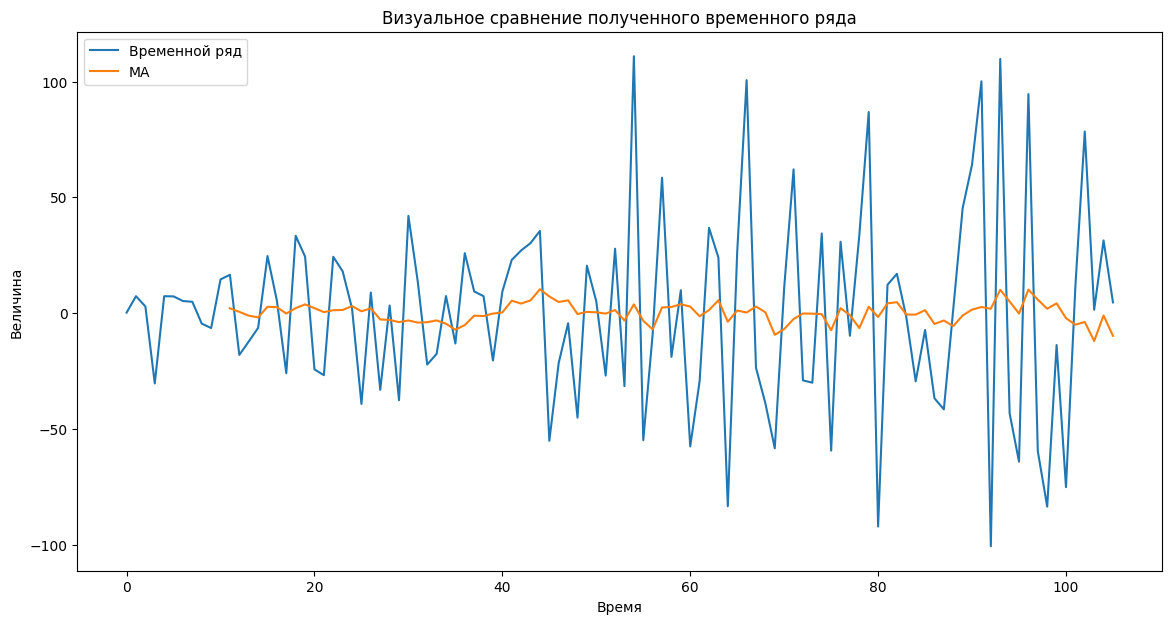

Root Mean Square Error (RMSE): 43.23921633931115


43.23921633931115

In [ ]:
# получим результат
ma_s = stationary.rolling(window).mean()

chart_2(stationary, ma_s, "MA")

# RMSE
rsme(stationary, ma_s, window)

##2. Взвешенное скользящеесреднее (WMA)

###2.1. Не стационарный ряд

In [ ]:
# возьмем красивую функцию из лекции
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [ ]:
# построение ряда Фибоначи
def fibonacci(n):
    fib_series = [0, 1]
    for i in range(2, n):
        fib_series.append(fib_series[-1] + fib_series[-2])
    return fib_series

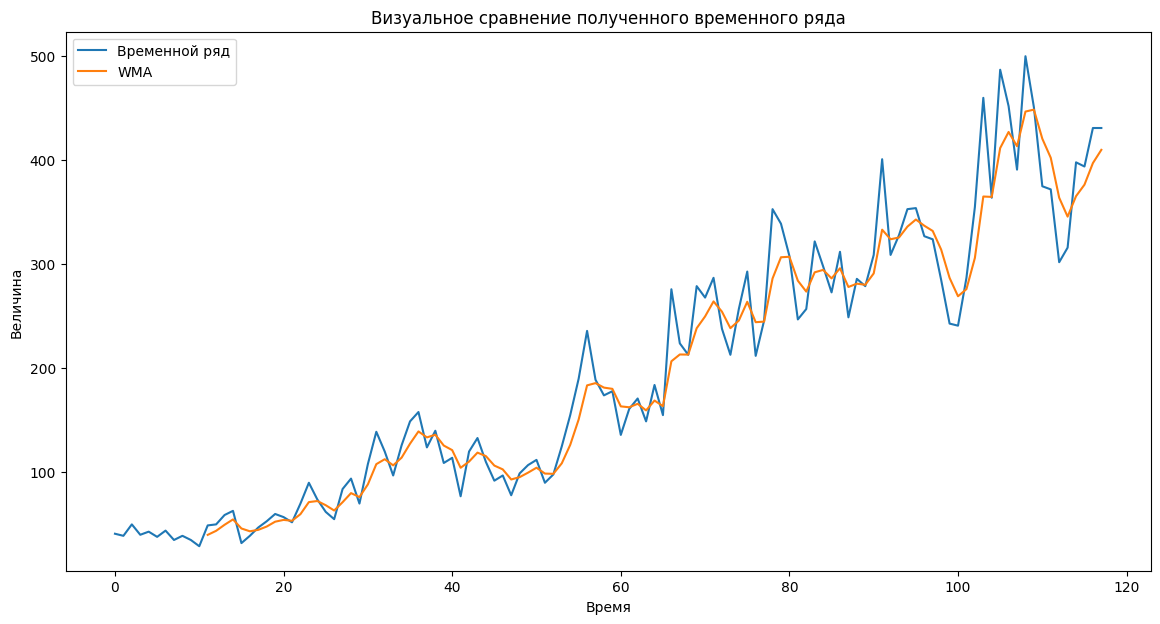

Root Mean Square Error (RMSE): 26.224851078055682


26.224851078055682

In [ ]:
# получим результат
wma = weighted_moving_average(series,
                              window,
                              weights=fibonacci(window))
chart_2(series, wma, "WMA")

# RMSE
rsme(series, wma, window)

###2.2 Стационарный ряд

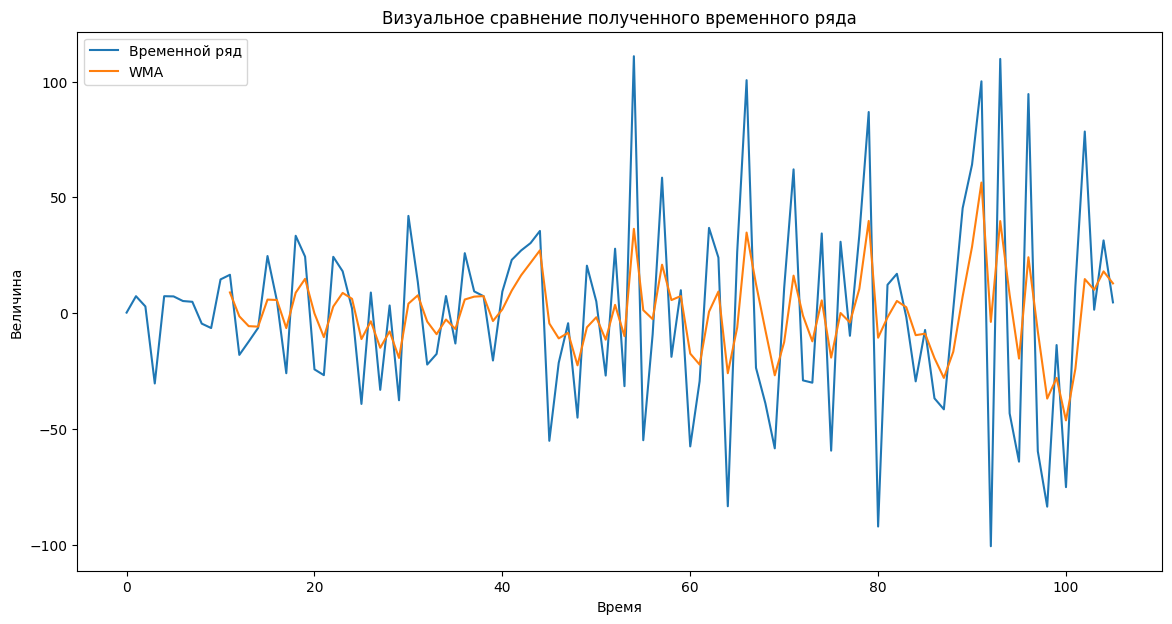

Root Mean Square Error (RMSE): 32.03120795117733


32.03120795117733

In [ ]:
# получим результат
wma_s = weighted_moving_average(stationary,
                              window,
                              weights=fibonacci(window))
chart_2(stationary, wma_s, "WMA")

# RMSE
rsme(stationary, wma_s, window)

##3. Экспоненциальное сглаживание (EMA)

###3.1. Не стационарный ряд

In [ ]:
# возьмем функцию из лекции
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [ ]:
alpha = 0.8

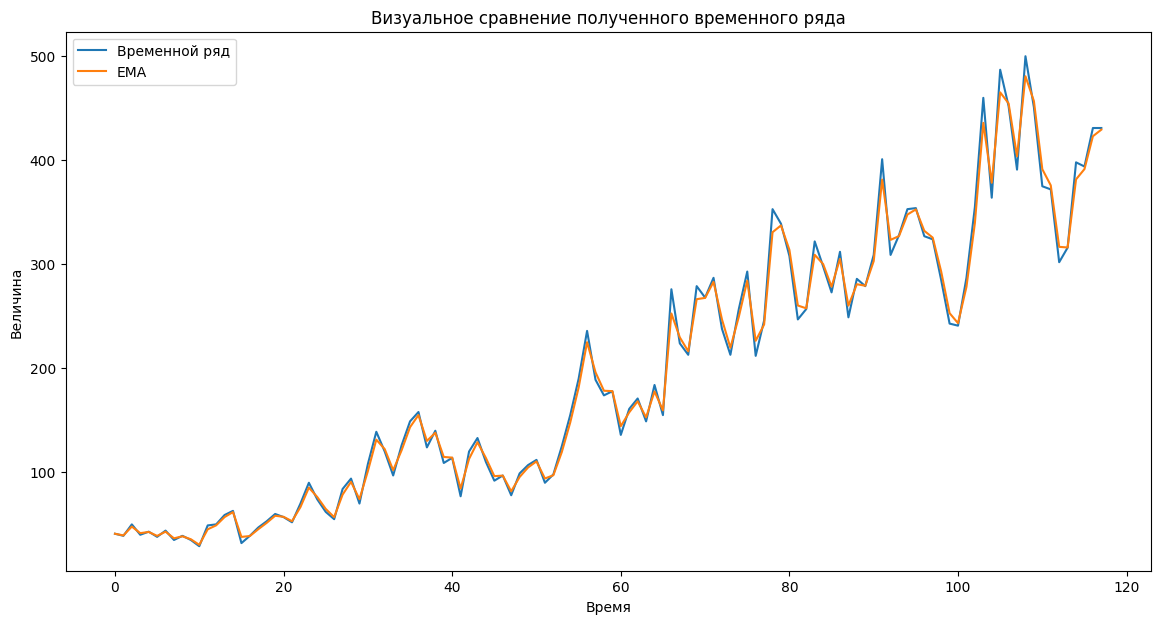

Root Mean Square Error (RMSE): 7.899906512351166


7.899906512351166

In [ ]:
# получим результат
ema = exponential_moving_average(series, alpha)

chart_2(series, ema, "EMA")

# RMSE
rsme(series, ema, 1)  # 1 - чтобы не пепеписывать функцию

###3.2. Стационарный ряд

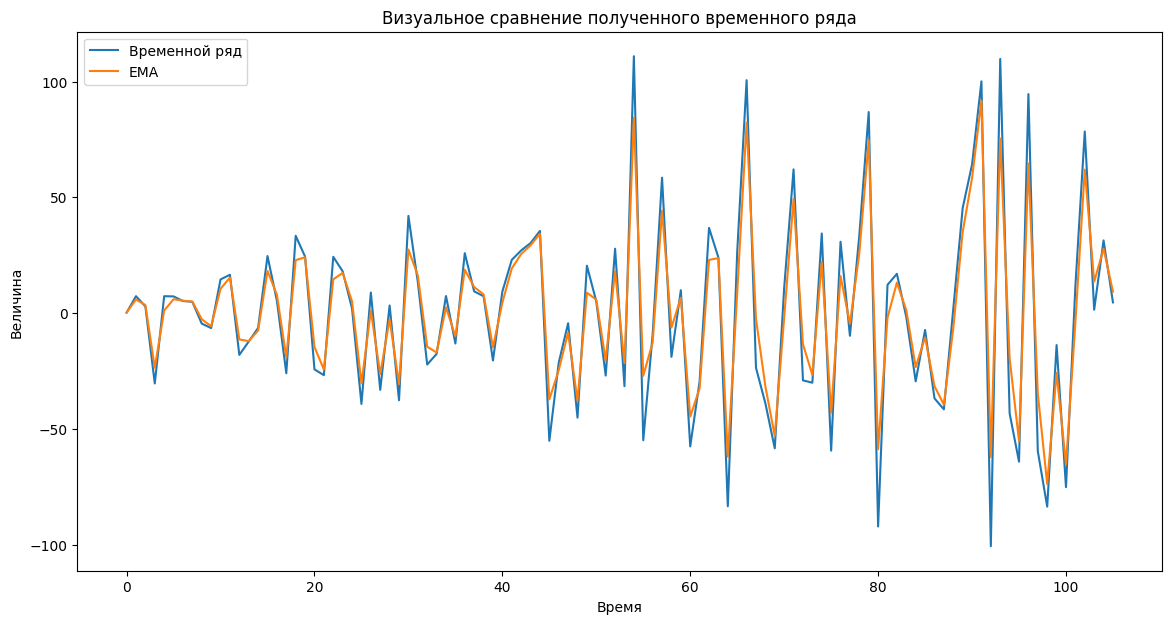

Root Mean Square Error (RMSE): 11.856067262277273


11.856067262277273

In [ ]:
# получим результат
ema_s = exponential_moving_average(stationary, alpha)

chart_2(stationary, ema_s, "EMA")

# RMSE
rsme(stationary, ema_s, window=1)  # 1 - чтобы не пепеписывать функцию

##4. Двойное экспоненциальное сглаживание (DEMA)

###4.1. Не стационарный ряд

In [ ]:
# возьмем функцию из декции
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [ ]:
alpha = 0.9
beta = 0.2

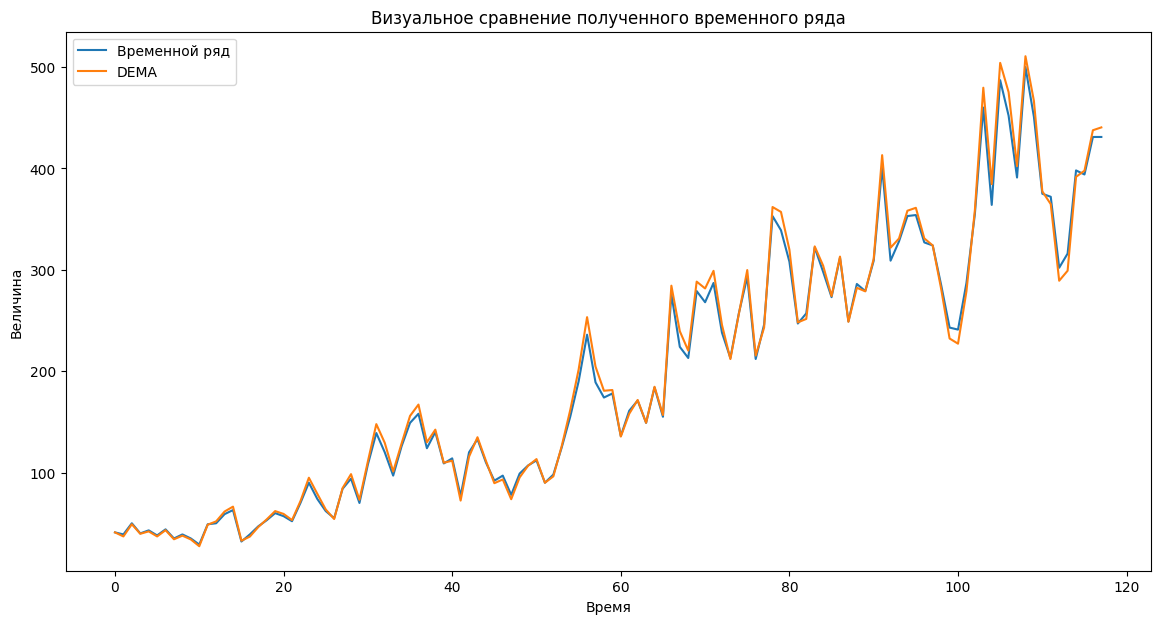

Root Mean Square Error (RMSE): 7.461089969221444


7.461089969221444

In [ ]:
# получим результат
dema = double_ema(series, alpha, beta)

chart_2(series, dema, "DEMA")

# RMSE
rsme(series, dema, 1)

###4.2. Стационарный ряд

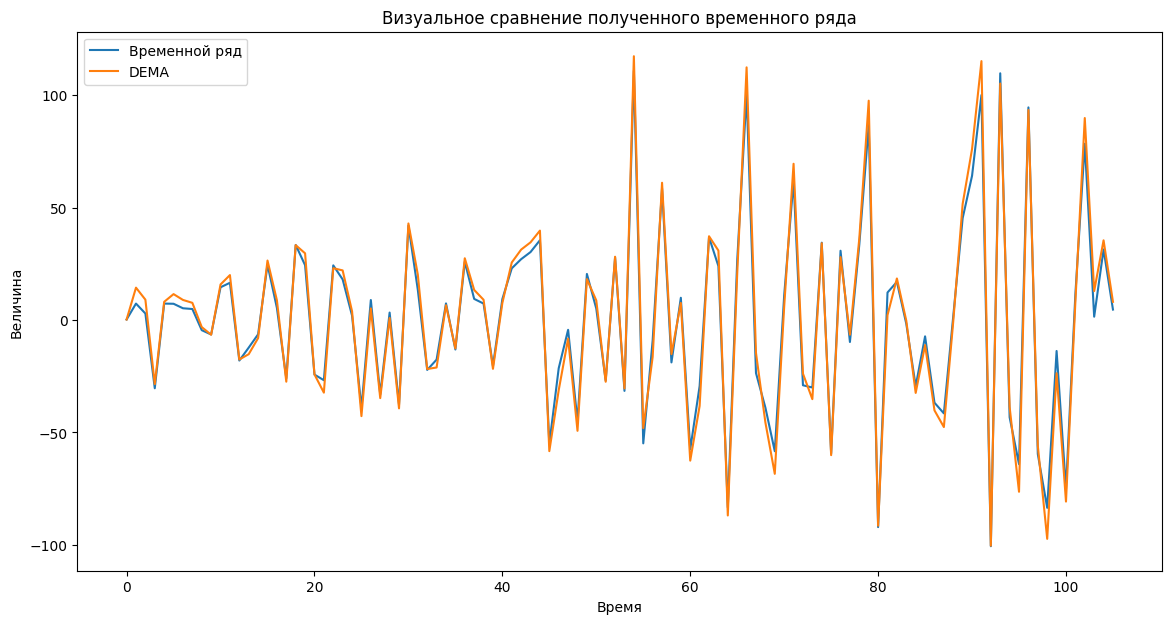

Root Mean Square Error (RMSE): 5.342725336156512


5.342725336156512

In [ ]:
# получим результат
dema_s = double_ema(stationary, alpha, beta)

chart_2(stationary, dema_s, "DEMA")

# RMSE
rsme(stationary, dema_s, 1)

##5. Тройное экспоненциальное сглаживание. Метод Хольта-Винтерса (TEMA)

###5.1. Не стационарный ряд

In [ ]:
# проверим биьлиотеку
import scipy
print(scipy.__version__)

1.13.1


In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [ ]:
# разобъем ряд
train, test, val = series[:60], series[60:70], series[70:]

Далее позаимствовал функции из лекции

In [ ]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [ ]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [ ]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [ ]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [ ]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [ ]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1947.268543541371
        x: [ 1.000e+00  7.511e-02  1.000e+00]
      nit: 6
      jac: [-4.218e+02  1.683e-03 -0.000e+00]
     nfev: 28
     njev: 7
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


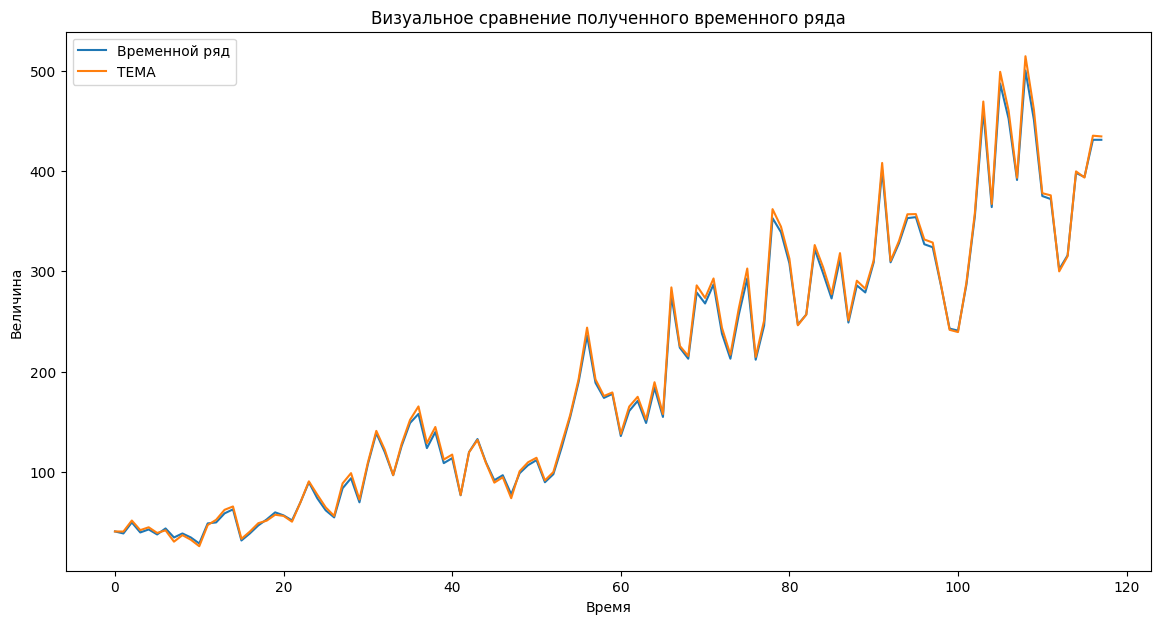

Root Mean Square Error (RMSE): 4.210089882863664


4.210089882863664

In [ ]:
# получим результат
_ = triple_exponential_smoothing(series, 12,
                                 alpha_opt, beta_opt, gamma_opt,
                                 n_preds=0)
tema = pd.Series(_)
chart_2(series, tema, 'TEMA')

# RMSE
rsme(series, tema, 1)

###5.2. Стационарный ряд

In [ ]:
# разобъем ряд
train, test, val = stationary[:60], stationary[60:70], stationary[70:]

In [ ]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [ ]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 2275.9708436173796
        x: [ 0.000e+00  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 1.061e+03  0.000e+00  2.899e+01]
     nfev: 4
     njev: 1
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


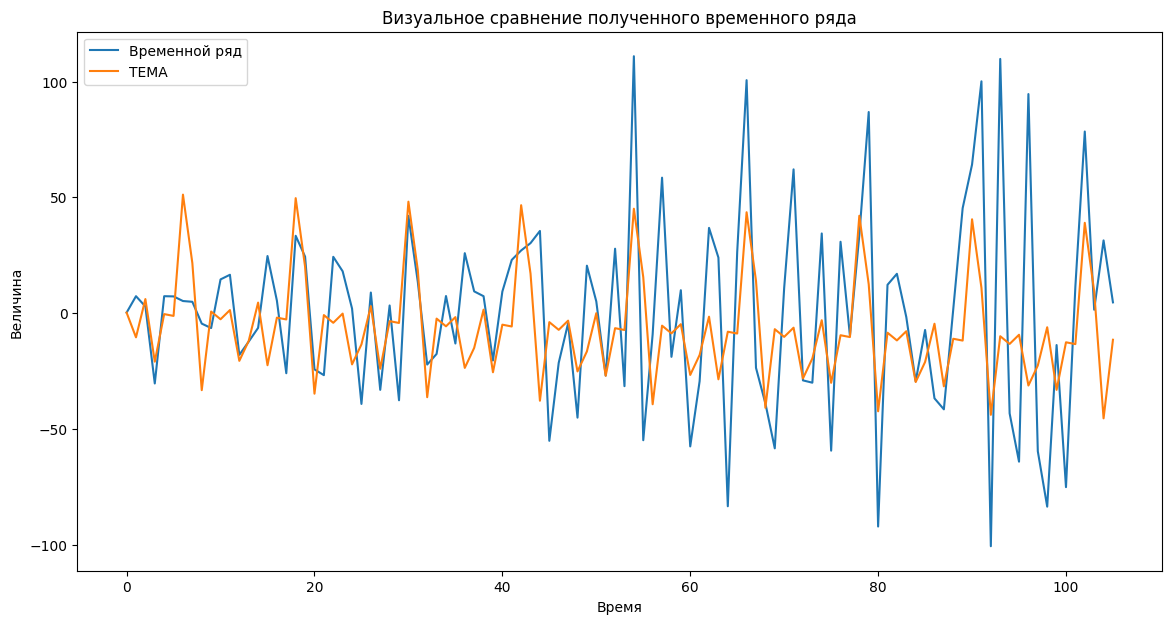

Root Mean Square Error (RMSE): 37.92095398555953


37.92095398555953

In [ ]:
# получим результат
_ = triple_exponential_smoothing(stationary, 12,
                                 alpha_opt, beta_opt, gamma_opt,
                                 n_preds=0)
tema = pd.Series(_)
chart_2(stationary, tema, 'TEMA')

# RMSE
rsme(stationary, tema, 1)

Общий вывод:
* Для не стационарного ряда ТЕМА показало ожидаемо лучший результат. Т.к. в исходном ряду были и тренд и сезонность.
* Для стационарно ряда лучшая модель - DEMA

